# Final Results

Analyze the results.

In the first part, calculate the metrics PER video and then average over them.

In the second part, aggregate ALL predictions and then compute the metrics on that.


In [23]:
import os
import pickle

In [24]:
import numpy as np

def round_with_std(mean, std):
    """
    Round the mean to match the significant digit of the std.
    """
    if std == 0:
        return f"{mean:.4f} ± 0"
    # Get the order of magnitude of the std
    order = -int(np.floor(np.log10(abs(std))))
    rounded_mean = round(mean, order)
    rounded_std = round(std, order)
    fmt_str = f"{{:.{order}f}} ± {{:.{order}f}}"
    return fmt_str.format(rounded_mean, rounded_std)

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)

def collect_predictions(all_video_results):
    y_true = []
    y_pred = []

    for video_results in all_video_results:
        for _, data in video_results.items():
            if not data.get('rejected', False):
                y_true.append(data['gt'])
                y_pred.append(data['pred'])
    return y_true, y_pred

def compute_aggregated_metrics(all_video_results,merge_classes=None):
    """
    Computes accuracy, precision, recall, and F1-score for multi-class classification,
    with optional merging of specific classes.

    Args:
        results (dict): Dictionary of frame results keyed by frame ID (e.g., '25').
        merge_classes (list of tuples, optional): List of class pairs to merge. 
            For example, [(3, 4), (6, 7)] will merge classes 3 & 4 and 6 & 7.

    Returns:
        dict: Dictionary containing accuracy, precision, recall, and F1-score.
    """
    per_video_metrics = []

    for video_results in all_video_results:
        y_true, y_pred = collect_predictions([video_results])
        if not y_true:
            continue

        # Apply class merging if specified
        if merge_classes:
            merge_map = {}
            for pair in merge_classes:
                for cls in pair:
                    merge_map[cls] = pair[0]  # Map all classes in the pair to the first class

            y_true = [merge_map.get(cls, cls) for cls in y_true]
            y_pred = [merge_map.get(cls, cls) for cls in y_pred]
        acc = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted', zero_division=0
        )
        per_video_metrics.append([acc, precision, recall, f1])

    if not per_video_metrics:
        return None

    metrics_array = np.array(per_video_metrics)
    mean = metrics_array.mean(axis=0)
    std = metrics_array.std(axis=0)

    return {
        "accuracy": round_with_std(mean[0], std[0]),
        "precision": round_with_std(mean[1], std[1]),
        "recall": round_with_std(mean[2], std[2]),
        "f1": round_with_std(mean[3], std[3])
    }

In [26]:
PREDS_PATH = "/work/courses/dslab/team14/videos/output/preds"
all_video_results = []
for pred in os.listdir(PREDS_PATH):
    if pred.endswith(".pkl"):
        with open(os.path.join(PREDS_PATH, pred), "rb") as f:
            preds = pickle.load(f)
            all_video_results.append(preds)
            

        

In [ ]:
print(f"A total of {len(all_video_results)} videos were processed.")
print("\nThese videos were processed:")
for pred in os.listdir(PREDS_PATH):
    print(f"- {pred}")

A total of 18 videos were processed.

These videos were processed:
- 12_run3.pkl
- 06_run2.pkl
- 11_run3.pkl
- 16_run2.pkl
- 17_run3.pkl
- 01_run1.pkl
- 04_run2.pkl
- 08_run3.pkl
- 06_run1.pkl
- 10_run3.pkl
- 08_run1.pkl
- 18_run2.pkl
- 11_run2.pkl
- 06_run3.pkl
- 12_run1.pkl
- 12_run2.pkl
- 17_run2.pkl
- 14_run1.pkl


## Metrics When Averaging the Computed Metrics for Each Video

This is without merging the classes:

In [30]:
compute_aggregated_metrics(all_video_results)

{'accuracy': '0.5 ± 0.1',
 'precision': '0.7 ± 0.1',
 'recall': '0.5 ± 0.1',
 'f1': '0.5 ± 0.1'}

Merging classes 4&5 and 6&7:

In [31]:
compute_aggregated_metrics(all_video_results,merge_classes=[(4, 5), (6, 7)])

{'accuracy': '0.81 ± 0.06',
 'precision': '0.84 ± 0.07',
 'recall': '0.81 ± 0.06',
 'f1': '0.81 ± 0.07'}

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_video_results=None, merge_classes=None, class_names=None):
    """
    Plot a confusion matrix for all videos combined, with optional class merging.

    Args:
        all_video_results (list): List of dictionaries containing predictions for each video.
        merge_classes (list of tuples, optional): List of class pairs to merge.
            For example, [(3, 4), (6, 7)] will merge classes 3 & 4 and 6 & 7.
        class_names (list, optional): List of class names for labeling the confusion matrix.
    """

    # Collect predictions and ground truths
    y_true, y_pred = collect_predictions(all_video_results)

    # Apply class merging if specified
    if merge_classes:
        merge_map = {}
        for pair in merge_classes:
            for cls in pair:
                merge_map[cls] = pair[0]  # Map all classes in the pair to the first class

        y_true = [merge_map.get(cls, cls) for cls in y_true]
        y_pred = [merge_map.get(cls, cls) for cls in y_pred]

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    

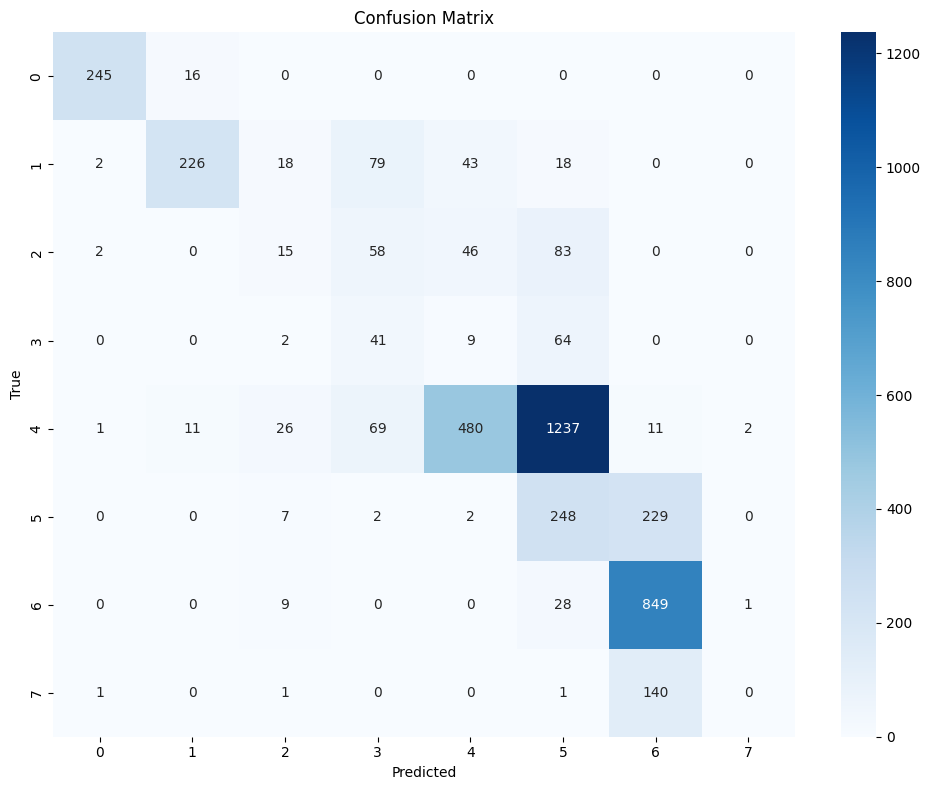

In [33]:
plot_confusion_matrix(all_video_results, class_names=["0", "1", "2", "3", "4", "5", "6", "7"])

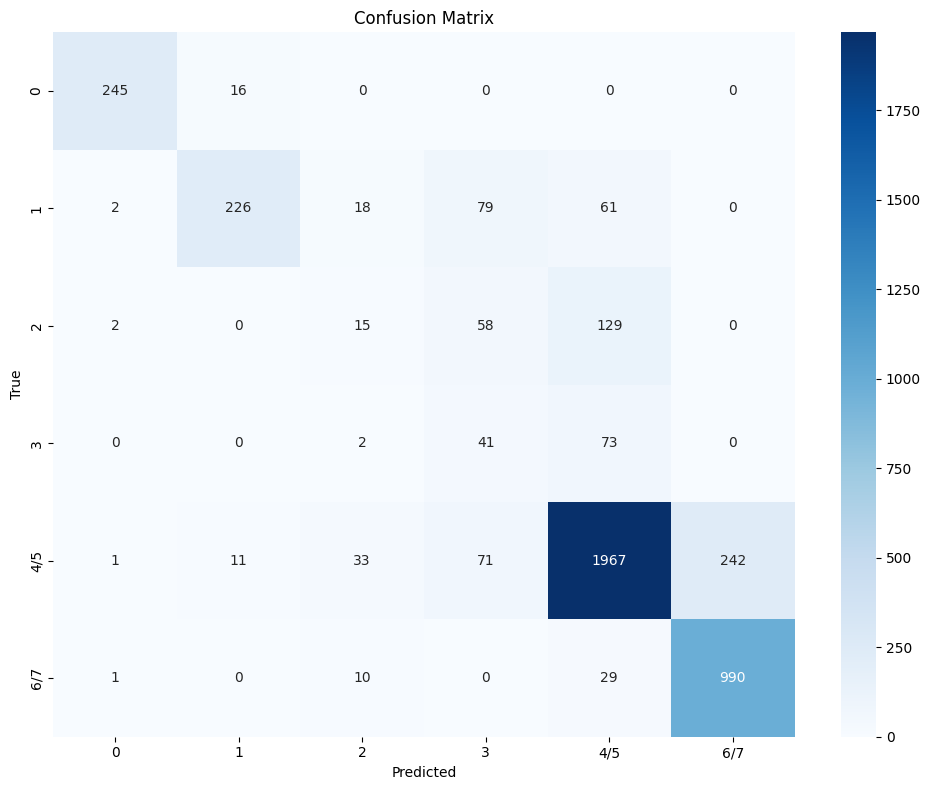

In [34]:
plot_confusion_matrix(all_video_results, merge_classes=[(4, 5), (6, 7)], class_names=["0", "1", "2", "3", "4/5", "6/7"])

## Computing Metrics After Aggregation

First aggregate all predictions, and then compute the metrics on that.

In [35]:
# aggregate all predictions
all_y_true, all_y_pred = collect_predictions(all_video_results)

def get_metrics(y_true, y_pred, merge_classes=None):
    """
    Compute accuracy, precision, recall, and F1-score for multi-class classification,
    with optional merging of specific classes.

    Args:
        y_true (list): Ground truth labels.
        y_pred (list): Predicted labels.
        merge_classes (list of tuples, optional): List of class pairs to merge.
            For example, [(3, 4), (6, 7)] will merge classes 3 & 4 and 6 & 7.

    Returns:
        dict: Dictionary containing accuracy, precision, recall, and F1-score.
    """
    # Apply class merging if specified
    if merge_classes:
        merge_map = {}
        for pair in merge_classes:
            for cls in pair:
                merge_map[cls] = pair[0]  # Map all classes in the pair to the first class

        y_true = [merge_map.get(cls, cls) for cls in y_true]
        y_pred = [merge_map.get(cls, cls) for cls in y_pred]

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }
# compute metrics
metrics = get_metrics(all_y_true, all_y_pred, merge_classes=[(4, 5), (6, 7)])
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}") 
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1-score: {metrics['f1']:.4f}")

Accuracy: 0.8061
Precision: 0.8121
Recall: 0.8061
F1-score: 0.8023
